In [10]:
from utils import *
from agent import *
import pygraphviz as pgv
from IPython.display import Image

In [ ]:
# Cargar el modelo de embeddings (sentence-transformers/all-MiniLM-L6-v2)
model = load_embedding_model()

# Eliminar todos los indices existentes en Pinecone
delete_all_pinecone_indexes()

# Datos de ejemplo (curriculums en formato csv extraidos de https://github.com/Hungreeee/Resume-Screening-RAG-Pipeline/blob/main/data/main-data/synthetic-resumes.csv)
process_resumes_individually("data/synthetic-resumes.csv", model)

In [3]:
def cv_query(query):
    agente_cv = GroqAgent()
    respuesta, total_tokens = query_with_agent(agente_cv, query)
    print(f"\nRespuesta final: {respuesta}")
    print(f"\nTotal de tokens usados: {total_tokens}")

In [4]:
# Query sin nombrar a nadie: se utiliza al alguien por defecto (Emma Johnson)
cv_query("Decime la experiencia laboral")

-----------
Iteracion 1
-----------
[GroqAgent] Usuario: Decime la experiencia laboral
[GroqAgent] Asistente: Pensamiento: Debería buscar el curriculum de Emma Johnson, ya que no se menciona a ninguna persona específica.

Acción: buscar_cv: Emma Johnson

PAUSA
[buscar_cv] Buscando CV para 'Emma Johnson'
-----------
Iteracion 2
-----------
[GroqAgent] Usuario: Observación: name : emma johnson contact information : email : emma. j @ email. com phone : 987 - 654 - 3210 location : pune, india summary : experienced ios developer with a strong command over swift and objective c. good knowledge of interface builder, core animation, and object oriented concepts. familiarity with frameworks & web technologies. excellent communication skills and pleasant in communication. education : bachelor of engineering in computer science ( bece ) skills : - strong command over swift and objective c - good knowledge of interface builder, core animation, and object oriented concepts - familiarity with framew

In [5]:
# Query nombrando a una persona
cv_query("¿Qué experiencia tiene George Smith?")

-----------
Iteracion 1
-----------
[GroqAgent] Usuario: ¿Qué experiencia tiene George Smith?
[GroqAgent] Asistente: Pensamiento: Debería buscar el curriculum de George Smith.
Acción: buscar_cv: George Smith
PAUSA
[buscar_cv] Buscando CV para 'George Smith'
-----------
Iteracion 2
-----------
[GroqAgent] Usuario: Observación: name : george smith location : bangalore, karnataka summary : a highly motivated devops engineer with 3 + years of experience in designing and implementing continuous integration and deployment solutions using jenkins and ansible. experienced in configuring and maintaining source code repositories using git. proficient in python and bash scripting. work experience : devops engineer pqr company, bangalore, karnataka june 2019 - present key responsibilities : - designed and implemented continuous integration and deployment solutions using jenkins and ansible - configured and maintained source code repositories using git - maintained communication with stakeholders a

In [6]:
# Query nombrando a dos personas
cv_query("Quiero un breve resumen de la experiencia laboral de Emma Johnson y George Smith")

-----------
Iteracion 1
-----------
[GroqAgent] Usuario: Quiero un breve resumen de la experiencia laboral de Emma Johnson y George Smith
[GroqAgent] Asistente: Pensamiento: Debería buscar el curriculum de Emma Johnson y George Smith para obtener información sobre su experiencia laboral.

Acción: buscar_multi_cv: Emma Johnson, George Smith

PAUSA
[buscar_multi_cv] Buscando CVs para 'Emma Johnson, George Smith'
[buscar_cv] Buscando CV para 'Emma Johnson'
[buscar_cv] Buscando CV para 'George Smith'
-----------
Iteracion 2
-----------
[GroqAgent] Usuario: Observación: name : emma johnson contact information : email : emma. j @ email. com phone : 987 - 654 - 3210 location : pune, india summary : experienced ios developer with a strong command over swift and objective c. good knowledge of interface builder, core animation, and object oriented concepts. familiarity with frameworks & web technologies. excellent communication skills and pleasant in communication. education : bachelor of engine

In [7]:
# Query nombrando a dos personas
cv_query("¿Comparten conocimiento en algún area específica John Robinson y Jane Doe?")

-----------
Iteracion 1
-----------
[GroqAgent] Usuario: ¿Comparten conocimiento en algún area específica John Robinson y Jane Doe?
[GroqAgent] Asistente: Pensamiento: Debería buscar los curriculums de John Robinson y Jane Doe para comparar sus áreas de conocimiento.

Acción: buscar_multi_cv: John Robinson, Jane Doe

PAUSA
[buscar_multi_cv] Buscando CVs para 'John Robinson, Jane Doe'
[buscar_cv] Buscando CV para 'John Robinson'
[buscar_cv] Buscando CV para 'Jane Doe'
-----------
Iteracion 2
-----------
[GroqAgent] Usuario: Observación: name : john robinson contact information : email : johnrobinson @ email. com phone : 555 - 555 - 5555 summary : experienced javascript developer with over 2 years of experience in developing applications and software using java. proficient in javascript, html, css, and react. skilled in developing responsive and user - friendly applications. skills : - proficient in javascript - experienced in html and css - skilled in react - knowledgeable in java - fam

In [8]:
# Query nombrando a a alguien que no reconoce
cv_query("¿Qué experiencia tiene Elon Musk?")

-----------
Iteracion 1
-----------
[GroqAgent] Usuario: ¿Qué experiencia tiene Elon Musk?
[GroqAgent] Asistente: Pensamiento: Debería buscar el curriculum de Elon Musk.
Acción: buscar_cv: Elon Musk
PAUSA
[buscar_cv] Buscando CV para 'Elon Musk'
-----------
Iteracion 2
-----------
[GroqAgent] Usuario: Observación: [buscar_cv] No se encontro un indice para 'Elon Musk'.
[GroqAgent] Asistente: Respuesta: No tengo la información disponible sobre la experiencia de Elon Musk.

Respuesta final: No tengo la información disponible sobre la experiencia de Elon Musk.

Total de tokens usados: 702


----
## Diagrama de flujo de la aplicación

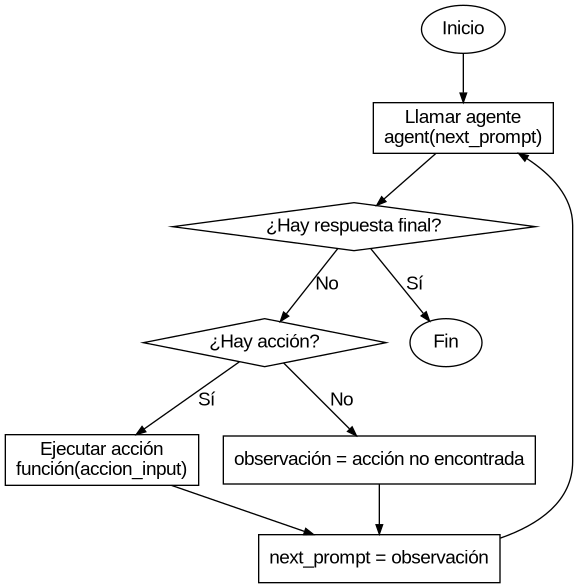

In [9]:
graph = pgv.AGraph(directed=True, rankdir="TB")

# Nodos principales
graph.add_node("Inicio", shape="ellipse", label="Inicio")
graph.add_node("Llamar agente", shape="box", label="Llamar agente\nagent(next_prompt)")
graph.add_node("¿Respuesta final?", shape="diamond", label="¿Hay respuesta final?")
graph.add_node("¿Acción?", shape="diamond", label="¿Hay acción?")
graph.add_node("Ejecutar acción", shape="box", label="Ejecutar acción\nfunción(accion_input)")
graph.add_node("Actualizar prompt", shape="box", label="next_prompt = observación")
graph.add_node("Acción no encontrada", shape="box", label="observación = acción no encontrada")
graph.add_node("Fin", shape="ellipse", label="Fin")

# Aristas
graph.add_edge("Inicio", "Llamar agente")
graph.add_edge("Llamar agente", "¿Respuesta final?")
graph.add_edge("¿Respuesta final?", "Fin", label="Sí")
graph.add_edge("¿Respuesta final?", "¿Acción?", label="No")
graph.add_edge("¿Acción?", "Ejecutar acción", label="Sí")
graph.add_edge("¿Acción?", "Acción no encontrada", label="No")
graph.add_edge("Ejecutar acción", "Actualizar prompt")
graph.add_edge("Acción no encontrada", "Actualizar prompt")
graph.add_edge("Actualizar prompt", "Llamar agente")

# Estilos
graph.graph_attr.update(bgcolor="white", fontname="Arial")
graph.node_attr.update(style="filled", fillcolor="white", fontname="Arial")
graph.edge_attr.update(fontname="Arial", arrowsize=0.7)

# Guardar y mostrar
graph.draw("media/agent_flow.png", format="png", prog="dot")
Image(filename="media/agent_flow.png")